This notebook is adapted from [this one](https://github.com/dataflowr/notebooks/blob/archive-2020/Notebooks/02_basics_pytorch.ipynb) written by [Marc Lelarge](https://www.di.ens.fr/~lelarge/), and from the tutorials [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#) and [Autograd: Automatic Differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

You can have access to more tutorials [here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

When you have questions, try as much as possible to find the answer by yourself looking at [PyTorch documentation](https://pytorch.org/docs/stable/index.html). You need to learn to work with the documentation.

In [17]:
%matplotlib inline

# Playing with PyTorch: Linear Regression

## Warm-up: Linear regression with numpy

We consider a dataset $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^N$  where $\mathbf{x}_i \in \mathbb{R}^2$ are the input features and $y_i \in \mathbb{R}$ the labels. The dataset is generated as follows:

$$ y_i = 2x_{1,i}-3x_{2,i}+1, \quad i\in\{1,\dots,N\},$$
where $\mathbf{x}_i = [x_{1,i}, x_{2,i}]^T$.

We define the following model:
$$ \hat{y}_i = w_1 x_{1,i} + w_2 x_{2,i} + b, \quad i\in\{1,\dots,N\}, $$

or equivalently in vector form:
$$ \hat{y}_i = \mathbf{w}^T\mathbf{x}_i + b, $$
where $\mathbf{w} = [w_1, w_2]^T$.

Our task is to recover the weights $w_1=2, w_2=-3$ and the bias $b = 1$ from the dataset $\mathcal{D}$.

In [18]:
import numpy as np
from numpy.random import random
import torch

# generate random input data
N = 30
x = random((N,2))

# generate labels corresponding to input data x
w_source = np.array([2., -3.])
b_source  = np.array([1.])

y = x @ w_source + b_source

Some visualization functions that you do not need to read:

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_figs(fig_num, elev, azim, x, y, weights, bias):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim, auto_add_to_figure=False)
    fig.add_axes(ax)
    ax.scatter(x[:, 0], x[:, 1], y)
    X = np.array([[0, 0], [1, 1]])
    Y = np.array([[0, 1], [0, 1]])
    Z = (np.array([[0, 0, 1, 1], [0, 1, 0, 1]]).T @ weights + bias).reshape((2, 2))
    # [Z]_ij = 2[X]_ij - 3[Y]_ij + 1
    ax.plot_surface(X,Y,Z,alpha=.5)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('y')
    
def plot_views(x, y, w, b):
    #Generate the different figures from different views
    elev = 10
    azim = -110
    plot_figs(1, elev, azim, x, y, w, b[0])

    plt.show()

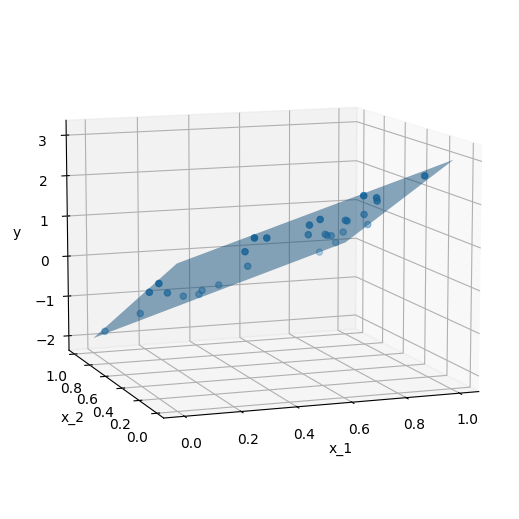

In [20]:
plt.figure(figsize=(7,5))
plot_views(x, y, w_source, b_source)

We want to minimize the following loss function with respect to $\mathbf{w}$ and $b$:
$$ \mathcal{L}(\mathbf{w}, b) = \frac{1}{N}\sum\limits_{i=1}^{N} \ell_i(\mathbf{w}, b), \qquad \text{with} \qquad \ell_i(\mathbf{w}, b) = \left(\mathbf{w}^T{\bf x}_i + b - y_i \right)^2. $$

We first compute the gradient of each term in this sum:
\begin{align*}
\frac{\partial{\ell_i}}{\partial w_1} &=& 2x_{1,i}\left({\bf w}^T{\bf x}_i+b-y_i \right);\\
\frac{\partial{\ell_i}}{\partial w_2} &=& 2x_{2,i}\left({\bf w}^T{\bf x}_i+b-y_i \right);\\
\frac{\partial{\ell_i}}{\partial b} &=& 2\left({\bf w}^T{\bf x}_i+b-y_i \right).
\end{align*}

For one epoch (one pass over the entire dataset), **stochastic gradient descent** updates the weigts and bias by running the following loop: 

for $i \in \{1,\dots,N\}$, 

\begin{align*}
w_1 &\leftarrow& w_{1} - \alpha\frac{\partial{\ell_i}}{\partial w_1}; \\
w_{2} &\leftarrow& w_{2} - \alpha\frac{\partial{\ell_i}}{\partial w_2}; \\
b &\leftarrow & b - \alpha\frac{\partial{\ell_i}}{\partial b};
\end{align*}
where $\alpha>0$ is called the learning rate.

Then we run several epochs.

Note that it is common to shuffle the dataset between two epochs, so that the order of the examples when iterating over $i \in \{1,\dots,N\}$ is not always the same.

initial values of the parameters: [0.66902116 0.28667905] [0.06129245]


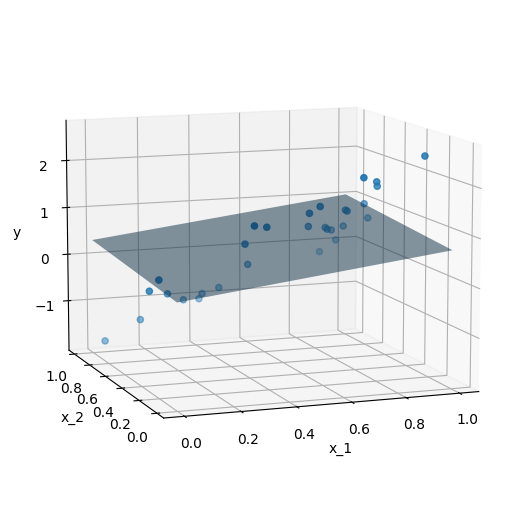

In [21]:
# randomly initialize learnable weights and bias
w_init = random(2)
b_init = random(1)

w = w_init
b = b_init
print("initial values of the parameters:", w, b )

# We plot the prediction with the randomly initialized parameters
plt.figure(figsize=(7,5))
plot_views(x, y, w, b)

Text(0.5, 1.0, 'training loss')

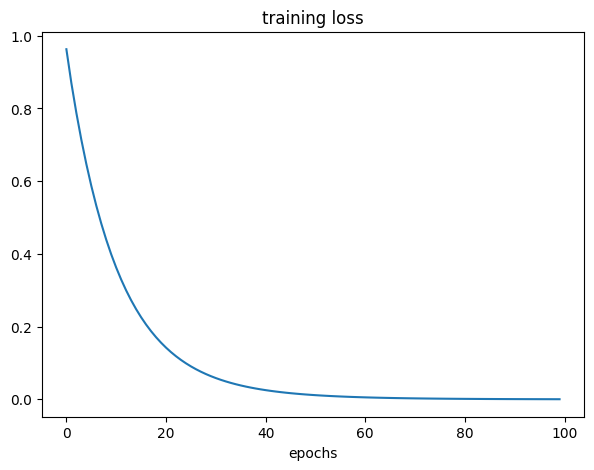

In [22]:
# our model forward pass
def forward(x):
    return x @ w + b

# Loss function
def loss(x, y):
    y_pred = forward(x)
    return (y_pred - y)**2 

# compute gradient
def gradient(x, y):  
    # returns dloss/dw, dloss/db
    return 2*(forward(x) - y)*x, 2*(forward(x) - y)
 
learning_rate = 1e-2

# Training loop with minibatch of size 1 (i.e., stochastic gradient descent)
train_loss = []
n_epochs = 100
for epoch in range(n_epochs):
    l = 0
    for x_i, y_i in zip(x, y):
        grad_w, grad_b = gradient(x_i, y_i)
        w = w - learning_rate * grad_w
        b = b - learning_rate * grad_b
        l += loss(x_i, y_i)
    train_loss.append(l/y.shape[0])

plt.figure(figsize=(7,5))
plt.plot(train_loss)
plt.xlabel('epochs')
plt.title('training loss')

estimation of the parameters: [ 2.03226917 -2.93627342] [0.94639111]


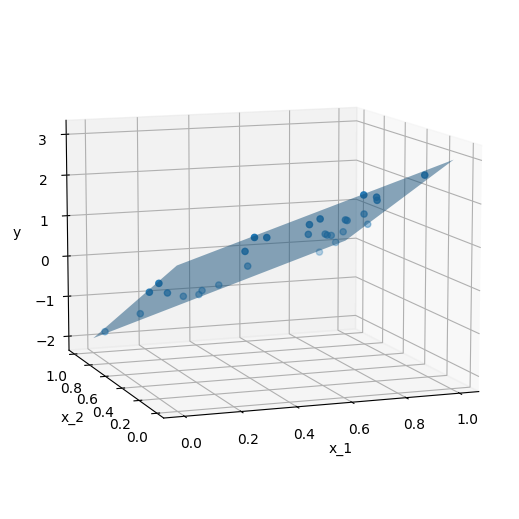

In [23]:
# After training
print("estimation of the parameters:", w, b )

plt.figure(figsize=(7,5))
plot_views(x, y, w, b)

The full gradients of the loss function are actually given by:
$$ \frac{\partial{\mathcal{L}}}{\partial w_1} = \frac{1}{N}\sum\limits_{i=1}^{N} \frac{\partial{\ell_i}}{\partial w_1},\quad
\frac{\partial{\mathcal{L}}}{\partial w_2} = \frac{1}{N}\sum\limits_{i=1}^{N} \frac{\partial{\ell_i}}{\partial w_2},\quad
\frac{\partial{\mathcal{L}}}{\partial b} = \frac{1}{N}\sum\limits_{i=1}^{N} \frac{\partial{\ell_i}}{\partial b}. $$

For one epoch, **standard gradient descent** updates the weights and bias as follows:
\begin{align*}
w_1 &\leftarrow& w_{1} - \alpha\frac{\partial{\mathcal{L}}}{\partial w_1}; \\
w_{2} &\leftarrow& w_{2} - \alpha\frac{\partial{\mathcal{L}}}{\partial w_2}; \\
b &\leftarrow & b - \alpha\frac{\partial{\mathcal{L}}}{\partial b};
\end{align*}

and then we run several epochs. Standard gradient descent is implemented in the following cells. For this simple linear regression example, you should not see much difference between standard gradient descent and its stochastic version because the loss function is convex.

initial values of the parameters: [0.66902116 0.28667905] [0.06129245]


Text(0.5, 1.0, 'training loss')

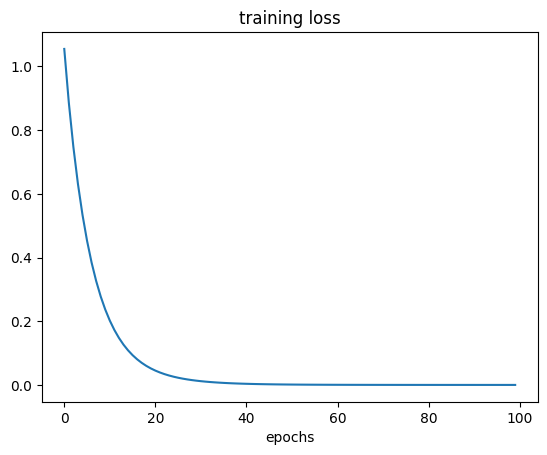

In [24]:
w = w_init
b = b_init

print("initial values of the parameters:", w, b )

learning_rate = 5e-1
train_loss = []
n_epochs = 100
for epoch in range(n_epochs):
    grad_w = np.array([0.0,0.0])
    grad_b = np.array([0.0])
    l = 0
    for x_i, y_i in zip(x, y):
        grad_w += gradient(x_i, y_i)[0]
        grad_b += gradient(x_i, y_i)[1]
        l += loss(x_i, y_i)
    grad_w /= N
    grad_b /= N
    w = w - learning_rate * grad_w
    b = b - learning_rate * grad_b
    train_loss.append(l/y.shape[0])

plt.plot(train_loss)
plt.xlabel('epochs')
plt.title('training loss')

estimation of the parameters: [ 2.00523067 -2.99312192] [0.99306256]


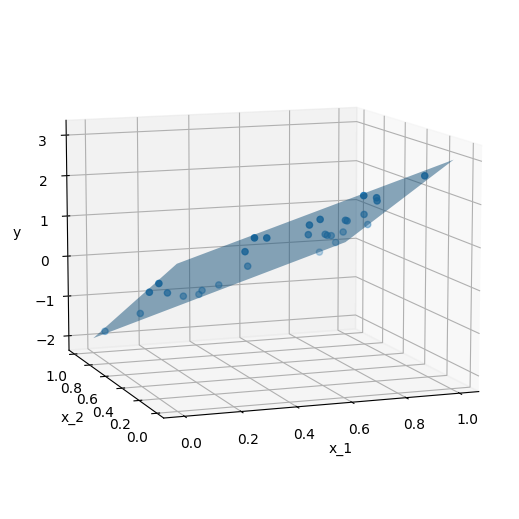

In [25]:
# After training
print("estimation of the parameters:", w, b)

plt.figure(figsize=(7,5))
plot_views(x, y, w, b)

## Linear regression with PyTorch tensors and Autograd

We start by converting our data into PyTorch tensors.

In [26]:
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU
x_t = torch.from_numpy(x).type(dtype)
y_t = torch.from_numpy(y).type(dtype).unsqueeze(1)
print(x_t.shape)
print(y_t.shape)

torch.Size([30, 2])
torch.Size([30, 1])


Below is an implementation of **gradient descent** with tensors and without computing explicitly the gradient, using autograd instead.

In [29]:
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w_init_t = torch.from_numpy(w_init).type(dtype)
b_init_t = torch.from_numpy(b_init).type(dtype)

w_v = w_init_t.clone().unsqueeze(1)
w_v.requires_grad_(True)

b_v = b_init_t.clone().unsqueeze(1)
b_v.requires_grad_(True)

print("Initial values of the parameters:", w_v.cpu().detach().numpy().squeeze(), b_v.cpu().detach().numpy().squeeze())

Initial values of the parameters: [0.6690211  0.28667906] 0.06129245


Text(0.5, 1.0, 'training loss')

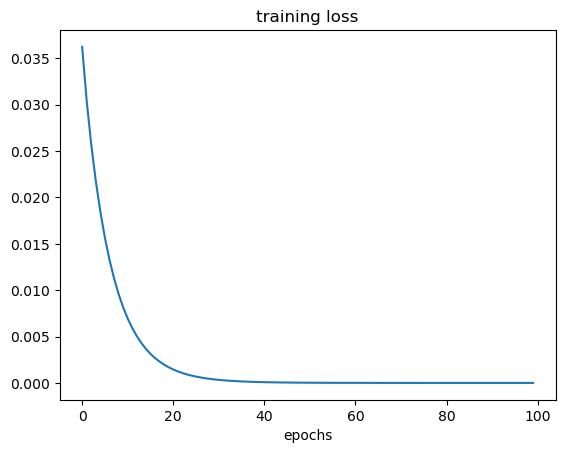

In [ ]:
learning_rate = 5e-1
train_loss = []
n_epochs = 100

for epoch in range(n_epochs):
    
    y_pred = x_t@ w_v + b_v
    loss = torch.mean((y_pred - y_t)**2)
    
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Variables with requires_grad=True.
    # After this call w.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to w and b respectively.
    loss.backward()
    
    # Update weights using gradient descent. For this step we just want to mutate
    # the values of w_v and b_v in-place; we don't want to build up a computational
    # graph for the update steps, so we use the torch.no_grad() context manager
    # to prevent PyTorch from building a computational graph for the updates
    with torch.no_grad():
        w_v -= learning_rate * w_v.grad
        b_v -= learning_rate * b_v.grad
    
    # Manually zero the gradients after updating weights
    # otherwise gradients will be acumulated after each .backward()
    w_v.grad.zero_()
    b_v.grad.zero_()
    
    train_loss.append(loss.item()/y_t.shape[0])

plt.plot(train_loss)
plt.xlabel('epochs')
plt.title('training loss')

estimation of the parameters: [0.6690211  0.28667906] 0.06129245


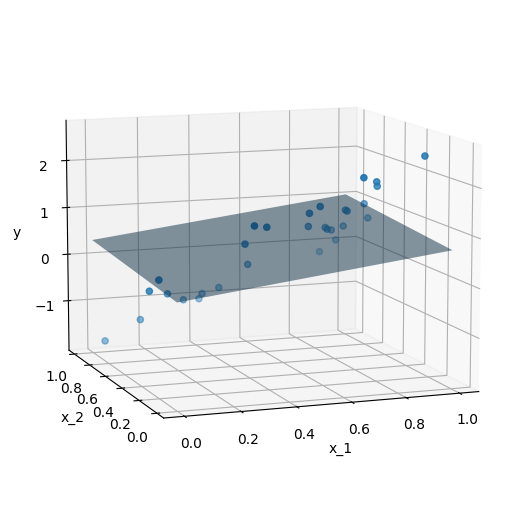

In [35]:
# After training
print("estimation of the parameters:", w_v.cpu().detach().numpy().squeeze(), b_v.cpu().detach().numpy().squeeze())

plt.figure(figsize=(7,5))
plot_views(x, y, w_v.cpu().detach().numpy(), b_v.cpu().detach().numpy())

You should obtain exactly the same result as standard gradient descent with numpy. 